# Extracting and processing OpenStreetMap (OSM) vector features for a **hotosm** area

- Current location: https://github.com/geohackweek/tutorial_contents/blob/master/vector/notebooks/.ipynb
- To be integrated into the GeoHackWeek [Vector tutorial](https://geohackweek.github.io/vector/)
- See https://github.com/geohackweek/vector/issues/23 for background resources and discussions
- Extract, handle as GeoPandas GeoDataFrames, and visualize building footprints and two types of "water" features

Emilio Mayorga, 6/3/2019

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import utm

import osmnx as ox
ox.config(use_cache=True, log_console=True)

In [2]:
gpd.__version__, ox.__version__

('0.5.0', '0.10')

Would be nice to map this with Folium ...

## Project area bounding box, from hotosm task 5678
The target area corresponds to [hotosm task 5678](https://tasks.hotosm.org/project/5678#bottom) with the following bounding box [104.917171, 16.330147, 105.805508, 15.294198].

In [3]:
bbox = [104.917171, 16.330147, 105.805508, 15.294198]
bbox_dct = dict(north=bbox[1], south=bbox[3], east=bbox[2], west=bbox[0])
bbox_ctr = [0.5*(bbox[1]+bbox[3]), 0.5*(bbox[0]+bbox[2])]

## Extract and explore building footprints

- See https://github.com/gboeing/osmnx-examples/blob/master/notebooks/10-building-footprints.ipynb and https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.footprints
- Geographic data returned as polygons (probably both `Polygon` and `MultiPolygon`)

### Read the footprints on a bbox, and return as a GeoPandas GeoDataFrame

In [4]:
buildings_gdf = ox.create_footprints_gdf(north=bbox[1], south=bbox[3], east=bbox[2], west=bbox[0],
                                         footprint_type='building')

In [5]:
# Number of buildings returned
len(buildings_gdf)

49364

In [6]:
buildings_gdf.columns

Index(['addr:city', 'addr:housenumber', 'addr:postcode', 'addr:street',
       'amenity', 'building', 'building:levels', 'building_1', 'geometry',
       'information', 'layer', 'man_made', 'name', 'name:en', 'name:th',
       'nodes', 'office', 'religion', 'source', 'tourism', 'type'],
      dtype='object')

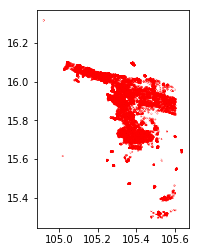

In [7]:
buildings_gdf.plot(edgecolor='red', linewidth=2);

In [8]:
buildings_gdf.head()

,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,building,building:levels,building_1,geometry,information,...,man_made,name,name:en,name:th,nodes,office,religion,source,tourism,type
563930739,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,"POLYGON ((105.0197648 15.6165799, 105.019847 1...",NaN,...,NaN,NaN,NaN,NaN,"[5434036492, 5434036493, 5434036494, 543403649...",NaN,NaN,NaN,NaN,NaN
673231291,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,"POLYGON ((105.3501838 15.6200281, 105.3502428 ...",NaN,...,NaN,NaN,NaN,NaN,"[6304620686, 6304620687, 6304620688, 630462068...",NaN,NaN,NaN,NaN,NaN
673231292,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,"POLYGON ((105.3489178 15.6205344, 105.3490143 ...",NaN,...,NaN,NaN,NaN,NaN,"[6304620690, 6304620691, 6304620692, 630462069...",NaN,NaN,NaN,NaN,NaN
673231293,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,"POLYGON ((105.3467023 15.6188192, 105.3466433 ...",NaN,...,NaN,NaN,NaN,NaN,"[6304620694, 6304620695, 6304620696, 630462069...",NaN,NaN,NaN,NaN,NaN
673231294,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,"POLYGON ((105.3445533 15.6212556, 105.3445305 ...",NaN,...,NaN,NaN,NaN,NaN,"[6304620698, 6304620699, 6304620700, 630462070...",NaN,NaN,NaN,NaN,NaN


### Explore the distributions of distinct values for some attributes

In [9]:
buildings_gdf['building'].value_counts()

yes               47532
house              1486
transportation      221
residential          76
garage               17
school                8
public                5
farm_auxiliary        5
shed                  4
detached              3
farm                  2
construction          2
barn                  1
greenhouse            1
warehouse             1
Name: building, dtype: int64

In [10]:
buildings_gdf['amenity'].value_counts()

place_of_worship    11
school               1
marketplace          1
Name: amenity, dtype: int64

In [11]:
buildings_gdf['source'].value_counts()

Digital Globe Standard                          180
Bing                                            174
DigitalGlobe Standard Imagery                     5
Digital Globe StandardDigital Globe Standard      1
DigitalSource Standard Imagery                    1
digitalglobe                                      1
Name: source, dtype: int64

### Distribution of building footprint area
Reproject to UTM in order to calculate building footprint polygon areas in $m^2$.

In [12]:
# Find corresponding UTM zone code
# https://gis.stackexchange.com/questions/190198/how-to-get-appropriate-crs-for-a-position-specified-in-lat-lon-coordinates
# https://gis.stackexchange.com/questions/269518/auto-select-suitable-utm-zone-based-on-grid-intersection

utmzone_code = utm.from_latlon(bbox_ctr[0], bbox_ctr[1])[-2:]
utmzone_epsg = 32700-round((45+bbox_ctr[0])/90.0)*100 + round((183+bbox_ctr[1])/6.0)
utmzone_code, utmzone_epsg

((48, 'P'), 32648)

I confirmed the conversion to epsg using `pyepsg`:
```python
import pyepsg
pyepsg.get(str(utmzone_epsg))
```

In [13]:
buildings_gdf_utm = buildings_gdf.to_crs(epsg=utmzone_epsg)

Print out simple stats, then a customized historgram

In [14]:
building_area_m2 = buildings_gdf_utm.geometry.area
building_area_m2.min(), building_area_m2.mean(), building_area_m2.median(), building_area_m2.max()

(0.018392478544626556,
 102.76593099832894,
 77.42572498586776,
 27972.521703074035)

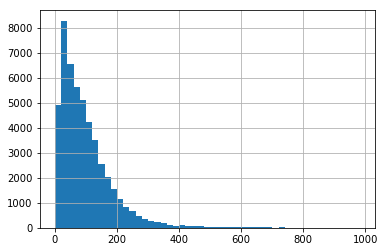

In [15]:
bins_seq = [i for i in range(0, 1000, 20)]
buildings_gdf_utm.geometry.area.hist(bins=bins_seq);

## Extract waterways from OSM

- On the same bbox as buildings
- Read into a "graph" first, then convert the graph edges to a geodataframe
- Note use of this scheme: `network_type='none', infrastructure='way["waterway"]'`
- Geographic data returned as lines (`linestring`)
- We'll use the `Other infrastructure` feature in OSMnx, illustrated at https://github.com/gboeing/osmnx-examples/blob/master/notebooks/16-work-with-other-infrastructures.ipynb
- "Waterways" are available from several tag types, specially "Waterway" and "Natural". See the following:
    - https://wiki.openstreetmap.org/wiki/Waterways
    - https://wiki.openstreetmap.org/wiki/Map_Features#Waterway
    - https://wiki.openstreetmap.org/wiki/Map_Features#Water_related
    - https://stackoverflow.com/questions/55033816/plotting-importing-rivers-in-osmnx

### Read `waterway` ways

In [16]:
waterways_g = ox.graph_from_bbox(**bbox_dct, network_type='none', infrastructure='way["waterway"]',
                                 retain_all=True, truncate_by_edge=True, simplify=False)

In [17]:
waterways_edges_gdf = ox.graph_to_gdfs(waterways_g, nodes=False)
len(waterways_edges_gdf)

51570

In [18]:
waterways_edges_gdf.head()

,geometry,highway,key,length,name,oneway,osmid,tunnel,u,v
0,"LINESTRING (105.406396 15.3067779, 105.4054477...",NaN,0,438.091,NaN,False,37334679,NaN,313516847,435187769
1,"LINESTRING (105.1836821 15.3144884, 105.183946...",NaN,0,132.931,NaN,False,198481252,NaN,313523792,408909266
2,"LINESTRING (105.1836821 15.3144884, 105.183366...",NaN,0,159.367,NaN,False,198481252,NaN,313523792,2086122728
3,"LINESTRING (105.1720284 15.3113008, 105.172273...",NaN,0,138.763,NaN,False,198487074,NaN,313523796,408903956
4,"LINESTRING (105.1720284 15.3113008, 105.171651...",NaN,0,94.558,NaN,False,198487074,NaN,313523796,2086175046


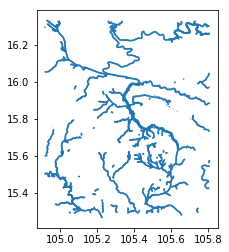

In [19]:
waterways_edges_gdf.plot();

### Read `natural:water` ways

In [20]:
natwater_g = ox.graph_from_bbox(**bbox_dct, network_type='none', infrastructure='way["natural"~"water"]',
                                retain_all=True, truncate_by_edge=True, simplify=False)

In [21]:
natwater_edges_gdf = ox.graph_to_gdfs(natwater_g, nodes=False)

In [22]:
natwater_edges_gdf.head()

,geometry,key,length,name,oneway,osmid,u,v
0,"LINESTRING (105.088 15.293, 105.09 15.29475)",0,289.624,NaN,False,37334031,435181079,435181090
1,"LINESTRING (105.07875 15.292, 105.09275 15.29925)",0,1704.308,NaN,False,37334031,435181085,435181086
2,"LINESTRING (105.09275 15.29925, 105.0935 15.299)",0,85.109,NaN,False,37334031,435181086,435181087
3,"LINESTRING (105.09275 15.29925, 105.07875 15.292)",0,1704.308,NaN,False,37334031,435181086,435181085
4,"LINESTRING (105.0935 15.299, 105.094 15.29825)",0,99.151,NaN,False,37334031,435181087,435181088


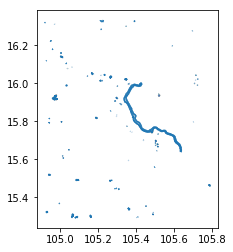

In [23]:
natwater_edges_gdf.plot();

## Plot all the OSM-derived layers on a single matplotlib plot

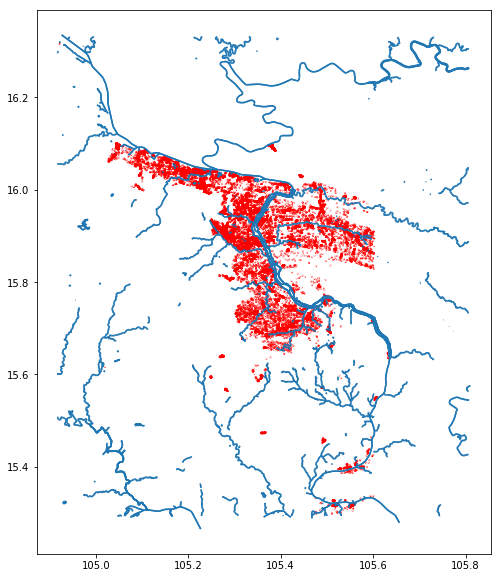

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
waterways_edges_gdf.plot(ax=ax)
natwater_edges_gdf.plot(ax=ax)
buildings_gdf.plot(ax=ax, edgecolor='red', linewidth=2);